In [3]:
import sys
sys.path.append("../../src")
import os
import csv
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from maneuvers import Maneuvers
import models, constants
import matplotlib.dates as mdates
import matplotlib.ticker as mticker
%load_ext autoreload
%autoreload 2


In [133]:
rp = 7000e3
ra = 8000e3
Omega = 340*np.pi/180
i = 65.1*np.pi/180
omega = 58*np.pi/180
nu = 332*np.pi/180
a = (rp+ra)/2
e = (ra-a)/a
coe = [a,e,i,omega,Omega,nu]

# Dates
startTime = "24 Feb 2012 16:00:00.000"
startDate = datetime.strptime(startTime,"%d %b %Y %H:%M:%S.000")
IdleTime = 60*60
ThrustingTime = 60*60*24*146/2
ThrustingTime2 = 60*60*24*146/2
Idle2Time = 60*60*24*30*2
stopDate = startDate + timedelta(seconds=IdleTime+ThrustingTime+ThrustingTime2+Idle2Time)
stopTime = str(stopDate.strftime("%d %b %Y %H:%M:%S.000"))
# Spacecraft
wetMass = 3
propMass = 2.9
area = 10
satellite = models.Spacecraft(wetMass,wetMass-propMass,area)

# Thruster
thrust = 1e-3
isp = 720
satellite.thruster = models.Thruster(thrust=thrust,isp=isp)

# Maneuvers
maneuver = Maneuvers(coe,satellite,startDate,formulation="betts")
maneuver.propagate(IdleTime,60);
maneuver.addPerturbation("thrust")
maneuver.propagate(ThrustingTime,60);
def alphaCallback(coe):
    return 0
def betaCallback(coe):
    return 90*np.pi/180
maneuver.thrustProfile = (alphaCallback,betaCallback)
maneuver.propagate(ThrustingTime2,60);
maneuver.removePerturbation("thrust")
maneuver.propagate(Idle2Time,60*60);

Propagating...from day  0.0  to  0.041666666666666664
Propagating...from day  0.041666666666666664  to  73.04166666666667
Propagating...from day  73.04166666666667  to  146.04166666666666
Propagating...from day  146.04166666666666  to  206.04166666666666


In [134]:
matlabCode = "\
try\n\
    componentAstrogator = scenario.ComponentDirectory.GetComponents('eComponentAstrogator');\n\
catch\n\
    app = actxserver('STK11.application');\n\
    app.UserControl = 1;\n\
    app.visible = 1;\n\
    root = app.Personality2;\n\
    root.NewScenario('Validation');\n\
    scenario = root.CurrentScenario;\n\
\n\
    scenario.SetTimePeriod('"+startTime+"','"+stopTime+"');\n\
    scenario.StartTime = '"+startTime+"';\n\
    scenario.StopTime = '"+stopTime+"';\n\
\n\
    root.ExecuteCommand('Animate * Reset');\n\
    %% Satellite Definition and Astrogator Init\n\
    try\n\
        scenario.Children.Unload('eSatellite','ValidationSat');\n\
    catch\n\
    end\n\
    satellite = scenario.Children.New('eSatellite','ValidationSat');\n\
    satellite.SetPropagatorType('ePropagatorAstrogator');\n\
    ASTG = satellite.Propagator;\n\
    MCS = ASTG.MainSequence;\n\
end\n\
%% Astrogator Config\n\
componentAstrogator = scenario.ComponentDirectory.GetComponents('eComponentAstrogator');\n\
engineModels = componentAstrogator.GetFolder('Engine Models');\n\
try\n\
    customThruster = engineModels.Item('customThruster');\n\
catch\n\
    customThruster = engineModels.DuplicateComponent('Constant Thrust and Isp','customThruster');\n\
end\n\
customThruster.Isp = "+str(isp)+";\n\
customThruster.Thrust = "+str(thrust)+";\n\
\n\
MCS.RemoveAll;\n\
\n\
initstate = MCS.Insert('eVASegmentTypeInitialState','Inner Orbit','-');\n\
initstate.OrbitEpoch = scenario.StartTime;\n\
initstate.SetElementType('eVAElementTypeModKeplerian');\n\
\n\
initstate.InitialState.DryMass = "+str(wetMass-propMass)+";\n\
initstate.InitialState.Cd = 2.2;\n\
initstate.InitialState.DragArea = "+str(area)+";\n\
initstate.InitialState.Cr = 1;\n\
initstate.InitialState.SRPArea = 20;\n\
\n\
initstate.FuelTank.FuelMass = "+str(propMass)+";\n\
\n\
initstate.Element.RadiusOfPeriapsis = "+str(rp/1e3)+";\n\
initstate.Element.Eccentricity = "+str(e)+";\n\
initstate.Element.Inclination = "+str(i*180/np.pi)+";\n\
initstate.Element.RAAN = "+str(Omega*180/np.pi)+";\n\
initstate.Element.ArgOfPeriapsis = "+str(omega*180/np.pi)+";\n\
initstate.Element.TrueAnomaly = "+str(nu*180/np.pi)+";\n\
\n\
propagate = MCS.Insert('eVASegmentTypePropagate','Propagate','-');\n\
propagate.PropagatorName = 'Earth Point Mass';\n\
propagate.Properties.Color = uint32(hex2dec('00ff00'));\n\
propagate.StoppingConditions.Item('Duration').Properties.Trip = "+str(IdleTime)+";\n\
\n\
dv1 = MCS.Insert('eVASegmentTypeManeuver','DV1','-');\n\
dv1.Properties.Color = uint32(hex2dec('00d3ff'));\n\
dv1.SetManeuverType('eVAManeuverTypeFinite');\n\
maneuver = dv1.Maneuver;\n\
maneuver.SetAttitudeControlType('eVAAttitudeControlThrustVector');\n\
maneuver.AttitudeControl.ThrustAxesName = 'Satellite VNC(Earth)';\n\
maneuver.AttitudeControl.ThrustVector.AssignXYZ(1,0,0);\n\
maneuver.Propagator.StoppingConditions.Item('Duration').Properties.Trip = "+str(ThrustingTime)+";\n\
maneuver.Propagator.PropagatorName = 'Earth Point Mass';\n\
maneuver.SetPropulsionMethod('eVAPropulsionMethodEngineModel','customThruster');\n\
\n\
dv2 = MCS.Insert('eVASegmentTypeManeuver','DV2','-');\n\
dv2.Properties.Color = uint32(hex2dec('00ffd3'));\n\
dv2.SetManeuverType('eVAManeuverTypeFinite');\n\
maneuver2 = dv2.Maneuver;\n\
maneuver2.SetAttitudeControlType('eVAAttitudeControlThrustVector');\n\
maneuver2.AttitudeControl.ThrustAxesName = 'Satellite VNC(Earth)';\n\
maneuver2.AttitudeControl.ThrustVector.AssignXYZ(0,1,0);\n\
maneuver2.Propagator.StoppingConditions.Item('Duration').Properties.Trip = "+str(ThrustingTime2)+";\n\
maneuver2.Propagator.PropagatorName = 'Earth Point Mass';\n\
maneuver2.SetPropulsionMethod('eVAPropulsionMethodEngineModel','customThruster');\n\
\n\
propagate2 = MCS.Insert('eVASegmentTypePropagate','Propagate','-');\n\
propagate2.PropagatorName = 'Earth Point Mass';\n\
propagate2.Properties.Color = uint32(hex2dec('00ff00'));\n\
propagate2.StoppingConditions.Item('Duration').Properties.Trip = "+str(Idle2Time)+";\n\
\n\
ASTG.RunMCS;\n\
\n\
keplerianElemsDP = satellite.DataProviders.Item('Astrogator Values').Group.Item('Keplerian Elems').Exec(scenario.StartTime, scenario.StopTime,60);\n\
maneuverDP = satellite.DataProviders.Item('Astrogator Values').Group.Item('Maneuver').Exec(scenario.StartTime, scenario.StopTime,60);\n\
keplerianElemsData = keplerianElemsDP.DataSets.ToArray;\n\
maneuverData = maneuverDP.DataSets.ToArray;\n\
maneuverData = maneuverData(:,2:end);\n\
table = cell2table([keplerianElemsData,maneuverData],'VariableNames',[keplerianElemsDP.DataSets.ElementNames;maneuverDP.DataSets.ElementNames(2:end)]);\n\
writetable(table,'STKValidationScriptMatlab_DataOut.csv');\n\
\n\
exit;";
print(matlabCode)

with open("STKValidationScriptMatlab.m", "w") as file:
    file.write(matlabCode)
os.system('matlab -nosplash -nodesktop -wait -r "run(\'STKValidationScriptMatlab.m\')"')

try
    componentAstrogator = scenario.ComponentDirectory.GetComponents('eComponentAstrogator');
catch
    app = actxserver('STK11.application');
    app.UserControl = 1;
    app.visible = 1;
    root = app.Personality2;
    root.NewScenario('Validation');
    scenario = root.CurrentScenario;

    scenario.SetTimePeriod('24 Feb 2012 16:00:00.000','17 Sep 2012 17:00:00.000');
    scenario.StartTime = '24 Feb 2012 16:00:00.000';
    scenario.StopTime = '17 Sep 2012 17:00:00.000';

    root.ExecuteCommand('Animate * Reset');
    %% Satellite Definition and Astrogator Init
    try
        scenario.Children.Unload('eSatellite','ValidationSat');
    catch
    end
    satellite = scenario.Children.New('eSatellite','ValidationSat');
    satellite.SetPropagatorType('ePropagatorAstrogator');
    ASTG = satellite.Propagator;
    MCS = ASTG.MainSequence;
end
%% Astrogator Config
componentAstrogator = scenario.ComponentDirectory.GetComponents('eComponentAstrogator');
engineModels = componentAstroga

0

In [136]:
data = {}
with open('STKValidationScriptMatlab_DataOut.csv', mode='r') as csv_file:
    csv_reader = csv.DictReader(csv_file)
    csv_list = list(csv_reader)
    for key in csv_list[0]:
        print(key)
        data[key] = []
    perc = 0
    for Idx,row in enumerate(csv_list):
        perc2 = Idx/len(csv_list)*100
        if np.floor(perc2) > np.floor(perc):
            print(np.floor(perc2))
            perc = np.floor(perc2)
        for key in row:
            if key == "Time":
                try:
                    data[key].append(datetime.strptime(row[key], '%d %b %Y %H:%M:%S.000000000'))
                except:
                    print(row)
            else:
                data[key].append(float(row[key]))
for key in data:
    data[key] = np.array(data[key])

Time
Altitude_Of_Apoapsis
Altitude_Of_Periapsis
Argument_of_Latitude
Argument_of_Periapsis
Eccentric_Anomaly
Eccentricity
Inclination
Longitude_Of_Ascending_Node
MeanAnomaly
Mean_Motion
Orbit_Period
RAAN
Radius_Of_Apoapsis
Radius_Of_Periapsis
Semimajor_Axis
Time_Past_Asc_Node
Time_Past_Periapsis
True_Anomaly
DeltaV
FuelMass
Fuel_Density
Fuel_Used
Inertial_DeltaV_Magnitude
Inertial_DeltaVx
Inertial_DeltaVy
Inertial_DeltaVz
Specific_Impulse
Tank_Pressure
Tank_Temperature
Thrust_Vector_X
Thrust_Vector_Y
Thrust_Vector_Z
Total_Mass
Total_Mass_Flow_Rate
1.0
2.0
3.0
4.0
5.0
6.0
7.0
8.0
9.0
10.0
11.0
12.0
13.0
14.0
15.0
16.0
17.0
18.0
19.0
20.0
21.0
22.0
23.0
24.0
25.0
26.0
27.0
28.0
29.0
30.0
31.0
32.0
33.0
34.0
35.0
36.0
37.0
38.0
39.0
40.0
41.0
42.0
43.0
44.0
45.0
46.0
47.0
48.0
49.0
50.0
51.0
52.0
53.0
54.0
55.0
56.0
57.0
58.0
59.0
60.0
61.0
62.0
63.0
64.0
65.0
66.0
67.0
68.0
69.0
70.0
71.0
72.0
73.0
74.0
75.0
76.0
77.0
78.0
79.0
80.0
81.0
82.0
83.0
84.0
85.0
86.0
87.0
88.0
89.0
90.0
91.0


<IPython.core.display.Javascript object>


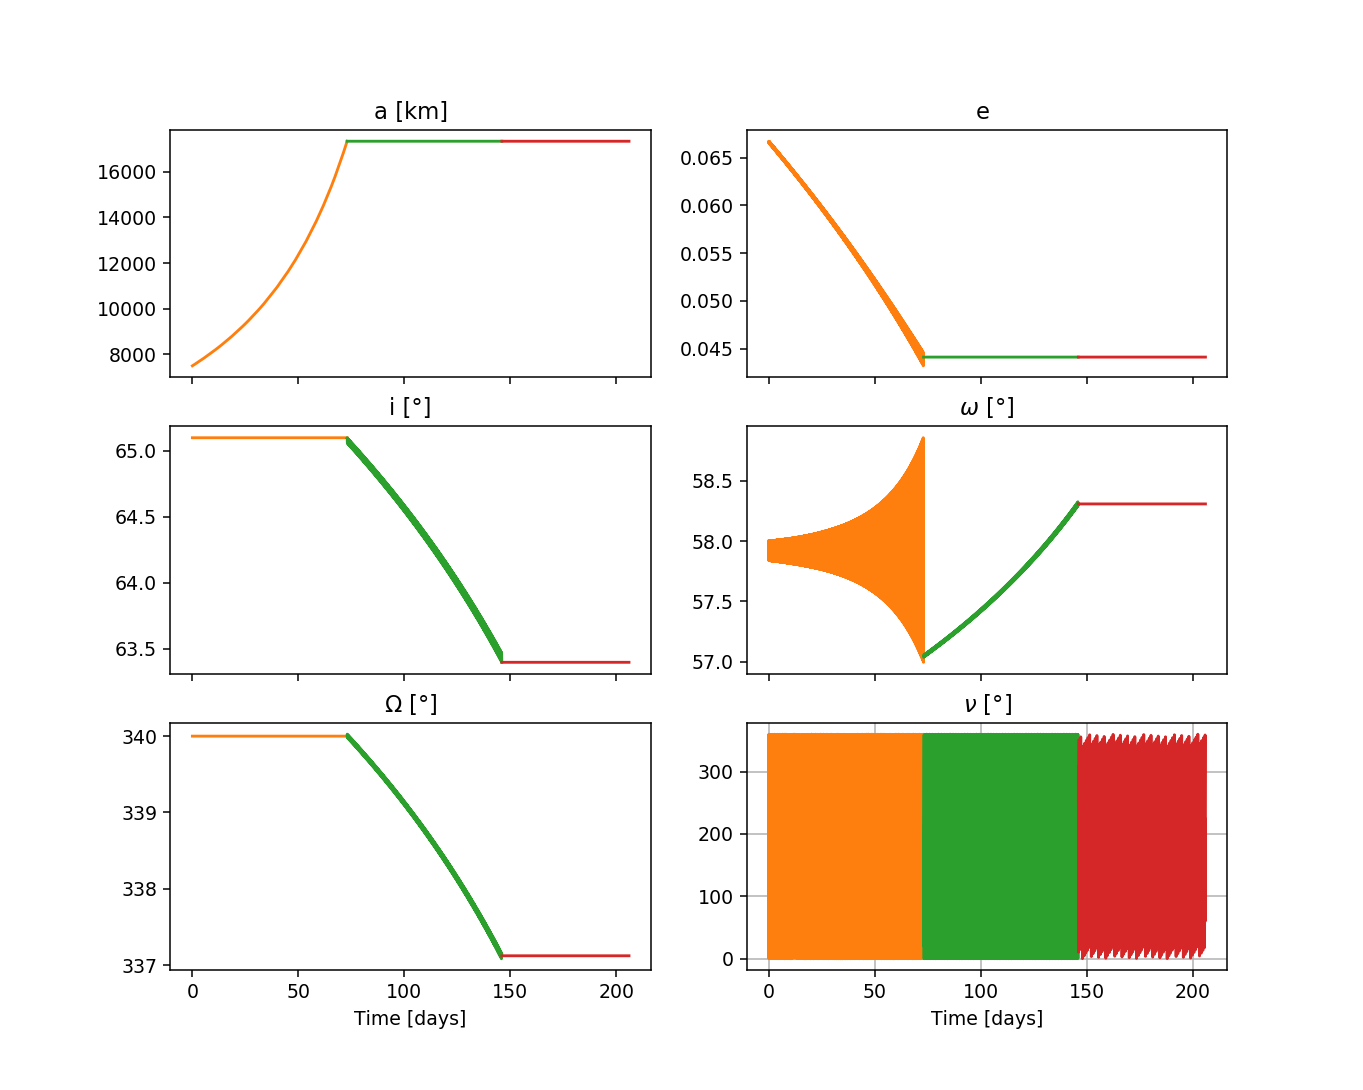

<IPython.core.display.Javascript object>


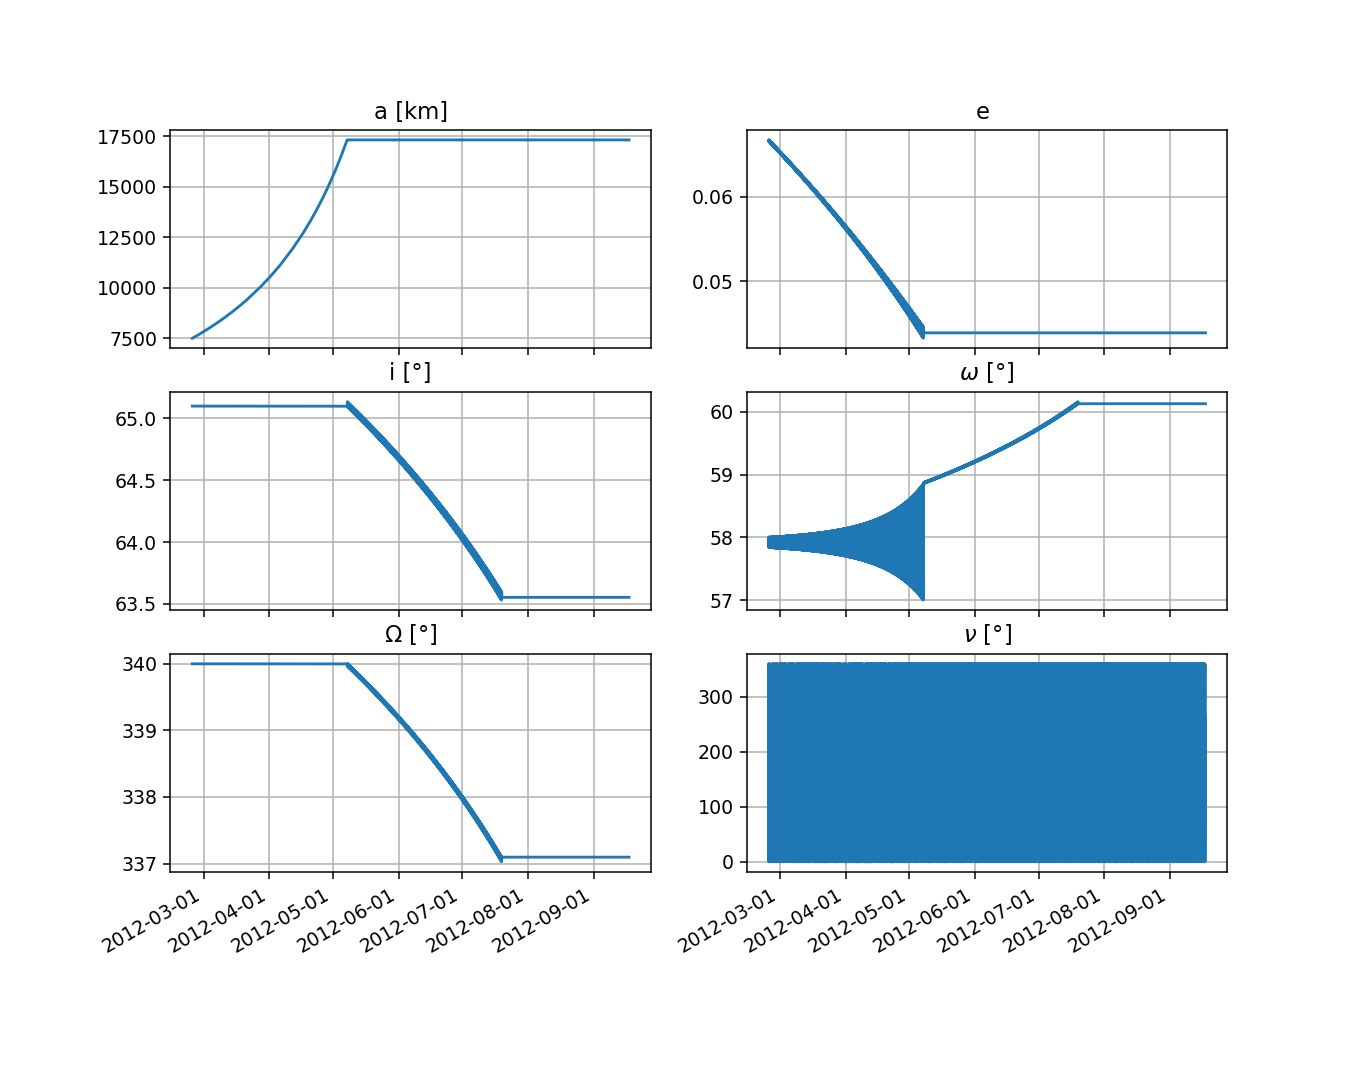

<IPython.core.display.Javascript object>


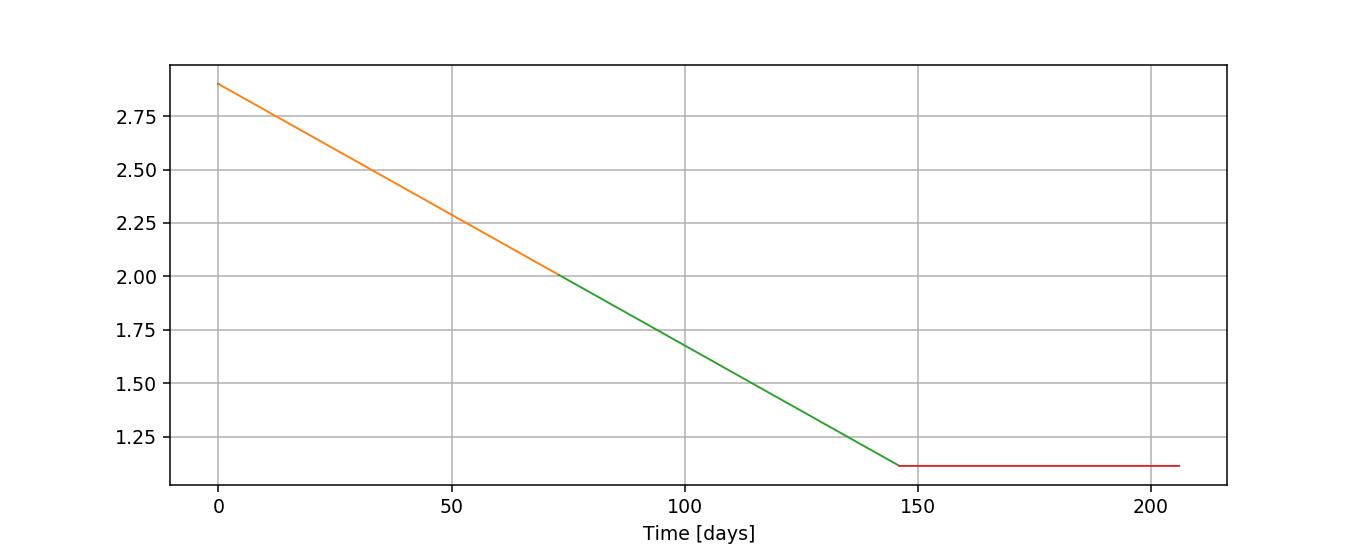

<IPython.core.display.Javascript object>


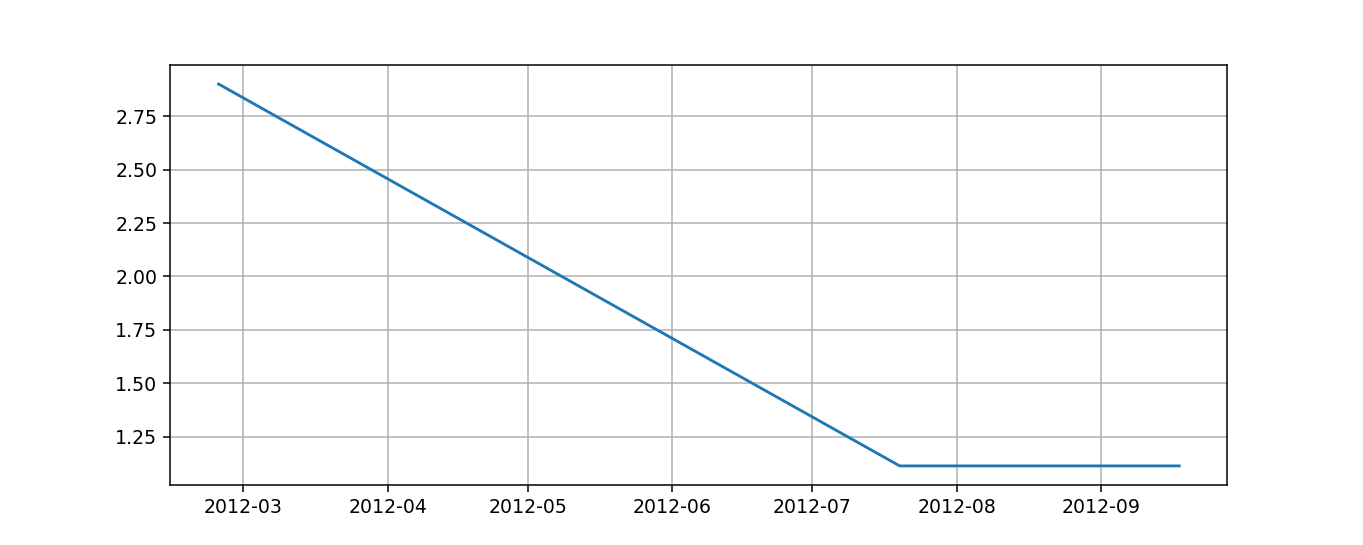

In [137]:
%config InlineBackend.figure_format = 'retina'
maneuver.plot("coe");
# PLOTTING CLASSICAL ORBITAL ELEMENTS
titles = ["a","e","i","$\omega$","$\Omega$","$\\nu$"]
ylabels = ["[km]", "", "[°]", "[°]", "[°]", "[°]"]
dictKeys = ["Semimajor_Axis","Eccentricity","Inclination","Argument_of_Periapsis","RAAN","True_Anomaly"]
fig, axes = plt.subplots(3,2,figsize=(10,8))
for i in range(0,6):
    if i in [2,3,4,5]:
        axes[int((i-i%2)/2),i%2].plot(data["Time"],data[dictKeys[i]])
    else:
        axes[int((i-i%2)/2),i%2].plot(data["Time"],data[dictKeys[i]])
    axes[int((i-i%2)/2),i%2].set_title(titles[i]+" "+ylabels[i])
    
    fig.autofmt_xdate()
    axes[int((i-i%2)/2),i%2].xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    axes[int((i-i%2)/2),i%2].yaxis.get_major_formatter().set_scientific(False)
    axes[int((i-i%2)/2),i%2].yaxis.get_major_formatter().set_useOffset(False)
    axes[int((i-i%2)/2),i%2].grid(b=True)
maneuver.plot("singleItem",maneuver.history.propMass)
plt.figure(figsize=(10,4))
plt.plot(data["Time"],data["FuelMass"])
plt.grid()

<IPython.core.display.Javascript object>


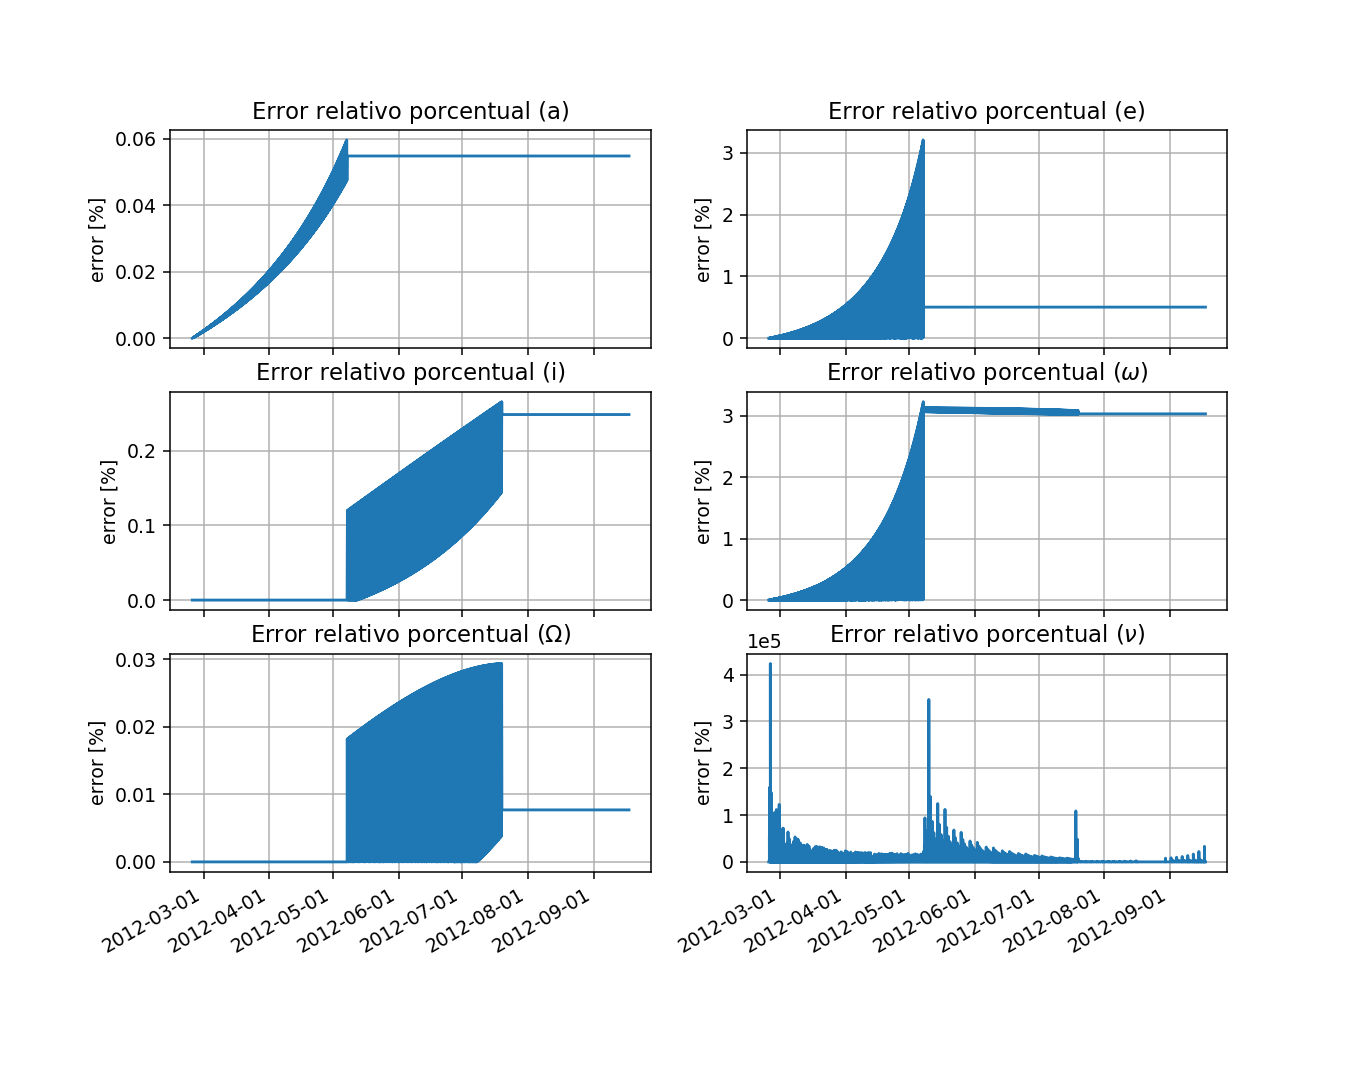

<IPython.core.display.Javascript object>


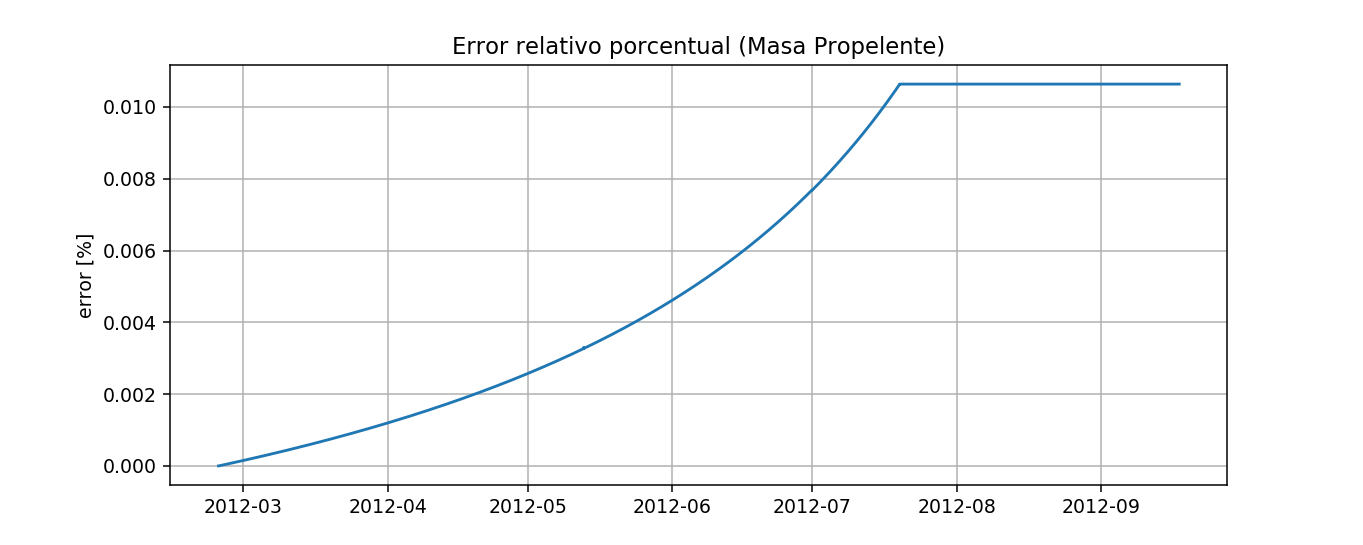

In [153]:
from scipy.interpolate import interp1d
def calculateRelativeError(t1,y1,t2,y2):
    t1_timestamps = np.array([d.timestamp() for d in t1])

    f = interp1d(t1_timestamps,y1)
    
    t2_timestamps = np.array([d.timestamp() for d in t2])


    y1_interp = f(t2_timestamps[1:-1])
    y1_interp = np.insert(y1_interp, 0, y1[0])
    y1_interp = np.append(y1_interp, y1[-1])

    return abs((y1_interp-y2)/y1_interp*100)

# PLOTTING CLASSICAL ORBITAL ELEMENTS
titles = ["a","e","i","$\omega$","$\Omega$","$\\nu$"]
ylabels = ["[%]", "", "[°]", "[°]", "[°]", "[°]"]
dictKeys = ["Semimajor_Axis","Eccentricity","Inclination","Argument_of_Periapsis","RAAN","True_Anomaly"]
fig, axes = plt.subplots(3,2,figsize=(10,8))
for i in range(0,6):
    if i == 0:
        relError = calculateRelativeError(data["Time"], data[dictKeys[i]], maneuver.history.datetime, maneuver.history.coe[:,i]/1e3)
    elif i in [2,3,4,5]:
        relError = calculateRelativeError(data["Time"], data[dictKeys[i]], maneuver.history.datetime, maneuver.history.coe[:,i]*180/np.pi)
    else:
        relError = calculateRelativeError(data["Time"], data[dictKeys[i]], maneuver.history.datetime, maneuver.history.coe[:,i])

    axes[int((i-i%2)/2),i%2].plot(maneuver.history.datetime,relError)
    axes[int((i-i%2)/2),i%2].set_title("Error relativo porcentual ("+titles[i]+")")
    axes[int((i-i%2)/2),i%2].set_ylabel("error [%]")
    fig.autofmt_xdate()
    axes[int((i-i%2)/2),i%2].xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    axes[int((i-i%2)/2),i%2].yaxis.get_major_formatter().set_scientific(False)
    axes[int((i-i%2)/2),i%2].yaxis.get_major_formatter().set_useOffset(False)
    if i == 5:
        axes[int((i-i%2)/2),i%2].ticklabel_format(style='sci',scilimits=(0,0),axis='y')
        axes[int((i-i%2)/2),i%2].yaxis.get_major_formatter().set_scientific(True)
    axes[int((i-i%2)/2),i%2].grid(b=True)
plt.figure(figsize=(10,4))
plt.plot(maneuver.history.datetime,calculateRelativeError(data["Time"],data["FuelMass"],maneuver.history.datetime,maneuver.history.propMass))
plt.ylabel("error [%]")
plt.title("Error relativo porcentual (Masa Propelente)")
plt.grid()